# **The Journey of Building a Credit Score Prediction Model**

# **Introduction**

In a world where financial inclusion depends on assessing creditworthiness, predicting customer credit scores with precision is a game-changer for financial institutions. This project was designed to tackle this challenge by creating a data-driven, machine learning-based credit scoring model that classifies customers into **Good**, **Poor**, or **Standard** credit score categories. By leveraging behavioral, financial, and demographic data, the project aimed to achieve accurate predictions and uncover insights into creditworthiness.

**Step 1: Understanding the Data**

The dataset provided a rich canvas of customer data:



*   **Demographics**: Age, Occupation, and Credit History Age.
*   **Financial Metrics**: Annual Income, Outstanding Debt, and Monthly Balance.
*   **Behavioral Data**: Payment behaviors, credit utilization, and loan history.

**Challenges Identified:**

1.   **Missing Values** in crucial columns like **`Monthly_Inhand_Salary`** and **`Type_of_Loan`**.
2.   **Inconsistent Data** such as negative ages and mixed data types.
3.   **Unstructured Columns** like **`Credit_History_Age`** requiring transformation.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import warnings

# Install the missing 'ace_tools' package
!pip install ace_tools
warnings.filterwarnings('ignore')

# Step 1: Load the Data
def load_data(file_path):
    """
    Load the dataset from the provided file path.
    :param file_path: str, path to the dataset
    :return: pd.DataFrame
    """
    credit_score_df = pd.read_csv(file_path)
    return credit_score_df

credit_score_df = load_data('/content/credit_score.csv')

In [ ]:
credit_score_df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529544,High_spent_Small_value_payments,312.4940887,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.2802216,Low_spent_Large_value_payments,284.6291625,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.69952126,Low_spent_Medium_value_payments,331.2098629,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580744,Low_spent_Small_value_payments,223.4513097,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.42015309,High_spent_Medium_value_payments,341.489231,Good


# **Step 2: Data Cleaning**

**Steps Taken:**

1. **Imputation**:
* Numerical columns (e.g., **`Monthly_Inhand_Salary`**) filled with median values.
* Categorical columns (e.g., **`Type_of_Loan`**) filled with placeholders like "Unknown."

2. **Correction**:
* Negative ages were replaced with absolute values.
* **`Credit_History_Age`** was parsed into total months (**`Credit_History_Months`**).

3. **Standardization**:
* Removed non-numeric characters from numerical columns like **`Monthly_Balance`**.

In [ ]:
# Data Cleaning Process
# Step 1: Handle missing values
# For numerical columns, use mean/median imputation
credit_score_df['Monthly_Inhand_Salary'].fillna(
    credit_score_df['Monthly_Inhand_Salary'].median(), inplace=True
)
credit_score_df['Num_Credit_Inquiries'].fillna(
    credit_score_df['Num_Credit_Inquiries'].median(), inplace=True
)

# For categorical columns, fill with a placeholder or most frequent value
credit_score_df['Type_of_Loan'].fillna('Unknown', inplace=True)
credit_score_df['Credit_History_Age'].fillna('0 Years and 0 Months', inplace=True)

# Step 2: Fix inconsistent formatting
# Correct negative ages
credit_score_df['Age'] = pd.to_numeric(credit_score_df['Age'], errors='coerce')
credit_score_df['Age'] = credit_score_df['Age'].apply(lambda x: abs(x) if x < 0 else x)

# Convert Credit_History_Age to total months
def parse_credit_history(age_str):
    if pd.isna(age_str) or not isinstance(age_str, str):
        return 0
    years, months = 0, 0
    if "Years" in age_str:
        years = int(age_str.split(" Years")[0])
    if "Months" in age_str:
        months = int(age_str.split("and ")[-1].split(" Months")[0])
    return years * 12 + months

credit_score_df['Credit_History_Months'] = credit_score_df['Credit_History_Age'].apply(parse_credit_history)

# Step 3: Convert mixed-type columns
# Remove any non-numeric characters from numerical columns and convert
credit_score_df['Monthly_Balance'] = pd.to_numeric(
    credit_score_df['Monthly_Balance'], errors='coerce'
)
credit_score_df['Amount_invested_monthly'] = pd.to_numeric(
    credit_score_df['Amount_invested_monthly'], errors='coerce'
)

# Confirm changes
cleaning_summary = {
    "Missing Values (Post)": credit_score_df.isna().sum(),
    "Dtypes": credit_score_df.dtypes,
    "Preview": credit_score_df.head(),
}
cleaning_summary

{'Missing Values (Post)': ID                             0
 Customer_ID                    0
 Month                          0
 Name                        9985
 Age                         4939
 SSN                            0
 Occupation                     0
 Annual_Income                  0
 Monthly_Inhand_Salary          0
 Num_Bank_Accounts              0
 Num_Credit_Card                0
 Interest_Rate                  0
 Num_of_Loan                    0
 Type_of_Loan                   0
 Delay_from_due_date            0
 Num_of_Delayed_Payment      7002
 Changed_Credit_Limit           0
 Num_Credit_Inquiries           0
 Credit_Mix                     0
 Outstanding_Debt               0
 Credit_Utilization_Ratio       0
 Credit_History_Age             0
 Payment_of_Min_Amount          0
 Total_EMI_per_month            0
 Amount_invested_monthly     8784
 Payment_Behaviour              0
 Monthly_Balance             1209
 Credit_Score                   0
 Credit_History_Months 

# **Step 3: Feature Engineering**

To maximize predictive power, new features were engineered:

1. **Behavioral Metrics**:
* `Payment_Behaviour_Score`: Mapped behavioral patterns to risk levels.
* `Payment_Min_Indicator`: Binary encoding for whether the minimum payment was made.

2. **Financial Metrics**:
* **`Debt-to-Income Ratio`** = **`Outstanding Debt`** /  **`Annual Income`**.

3. **Demographics**:
* **`Age_Group`**: Categorized ages into bins (e.g., 20-30, 30-40).
* Encoded `Occupation` as numerical values.

In [ ]:
# Feature Engineering Process

# 1. Behavioral Features
# Map Payment_Behaviour to risk scores
payment_behaviour_mapping = {
    "High_spent_Small_value_payments": 1,
    "Low_spent_Large_value_payments": 3,
    "Low_spent_Medium_value_payments": 2,
    "Low_spent_Small_value_payments": 1,
    "High_spent_Medium_value_payments": 2,
}
credit_score_df['Payment_Behaviour_Score'] = credit_score_df['Payment_Behaviour'].map(payment_behaviour_mapping)

# Convert Payment_of_Min_Amount into binary
payment_min_mapping = {'Yes': 1, 'No': 0}
credit_score_df['Payment_Min_Indicator'] = credit_score_df['Payment_of_Min_Amount'].map(payment_min_mapping)

# 2. Financial Features
# Convert Outstanding_Debt and Annual_Income to numeric for calculations
credit_score_df['Outstanding_Debt'] = pd.to_numeric(credit_score_df['Outstanding_Debt'], errors='coerce')
credit_score_df['Annual_Income'] = pd.to_numeric(credit_score_df['Annual_Income'], errors='coerce')

# Compute Debt-to-Income Ratio
credit_score_df['Debt_to_Income_Ratio'] = credit_score_df['Outstanding_Debt'] / credit_score_df['Annual_Income']

# 3. Demographic Features
# Bin Age into groups
age_bins = [0, 20, 30, 40, 50, 60, 100]
age_labels = ['<20', '20-30', '30-40', '40-50', '50-60', '60+']
credit_score_df['Age_Group'] = pd.cut(credit_score_df['Age'], bins=age_bins, labels=age_labels, right=False)

# Encode Occupation as a categorical feature
credit_score_df['Occupation_Encoded'] = credit_score_df['Occupation'].astype('category').cat.codes

# Feature Engineering Summary
feature_summary = credit_score_df[
    ['Payment_Behaviour_Score', 'Payment_Min_Indicator', 'Debt_to_Income_Ratio', 'Age_Group', 'Occupation_Encoded']
].head()

feature_summary

,Payment_Behaviour_Score,Payment_Min_Indicator,Debt_to_Income_Ratio,Age_Group,Occupation_Encoded
0,1.0,0.0,0.042376,20-30,12
1,3.0,0.0,0.042376,20-30,12
2,2.0,0.0,0.042376,NaN,12
3,1.0,0.0,0.042376,20-30,12
4,2.0,0.0,0.042376,20-30,12


# **Step 4: Visualizing the Story**

Visualizations unveiled hidden patterns and relationships in the data:

* Distribution of Credit Scores:
   * A count plot showed the dominance of the “Standard” category, followed by “Poor” and “Good.”
* Age Distribution:
   * Most customers fell into the 20-40 age bracket, with relatively fewer older customers.
* Debt-to-Income Ratio:
   * Higher ratios were correlated with lower credit scores.
* Correlation Matrix:
   * Identified strong relationships between features like **`Credit_History_Months`** and **`Credit Score`**.

**Insights:**

* Behavioral factors like payment behavior significantly influence credit scores.
* Demographic features, especially age and occupation, show distinct credit score trends.
* Financial stability (low debt-to-income ratio) is a key predictor of a good credit score.

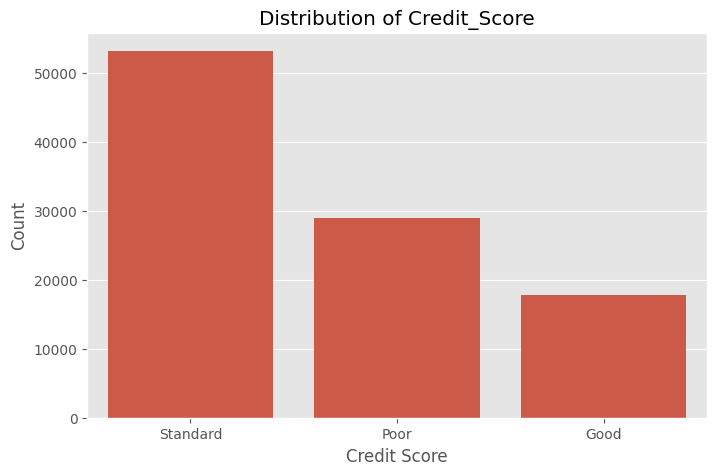

In [ ]:
# Configure visualization defaults
plt.style.use('ggplot')

# Step 1: Target Variable Analysis - Distribution of Credit_Score
plt.figure(figsize=(8, 5))
sns.countplot(x='Credit_Score', data=credit_score_df, order=credit_score_df['Credit_Score'].value_counts().index)
plt.title('Distribution of Credit_Score')
plt.xlabel('Credit Score')
plt.ylabel('Count')
plt.show()

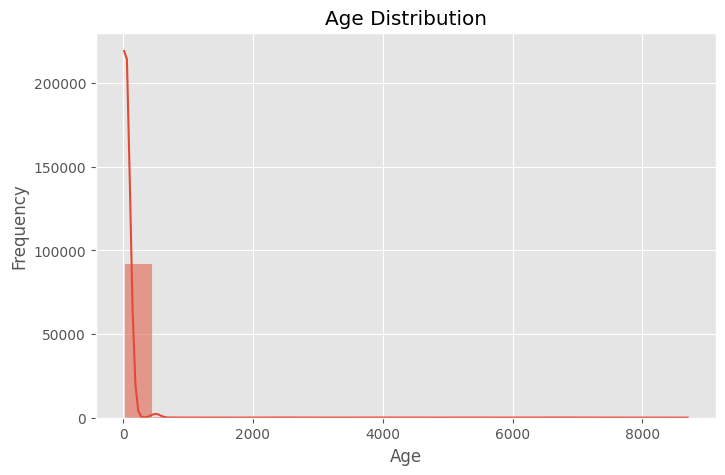

In [ ]:
# Step 2: Feature Distributions
# Distribution of Age
plt.figure(figsize=(8, 5))
sns.histplot(credit_score_df['Age'].dropna(), kde=True, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

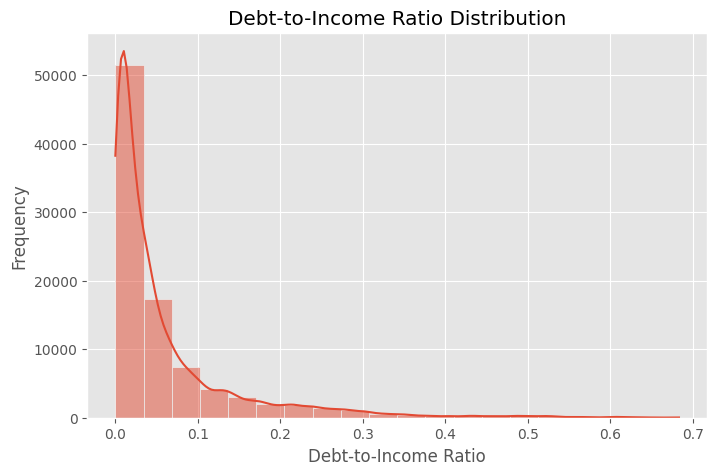

In [ ]:
# Distribution of Debt_to_Income_Ratio
plt.figure(figsize=(8, 5))
sns.histplot(credit_score_df['Debt_to_Income_Ratio'].dropna(), kde=True, bins=20)
plt.title('Debt-to-Income Ratio Distribution')
plt.xlabel('Debt-to-Income Ratio')
plt.ylabel('Frequency')
plt.show()

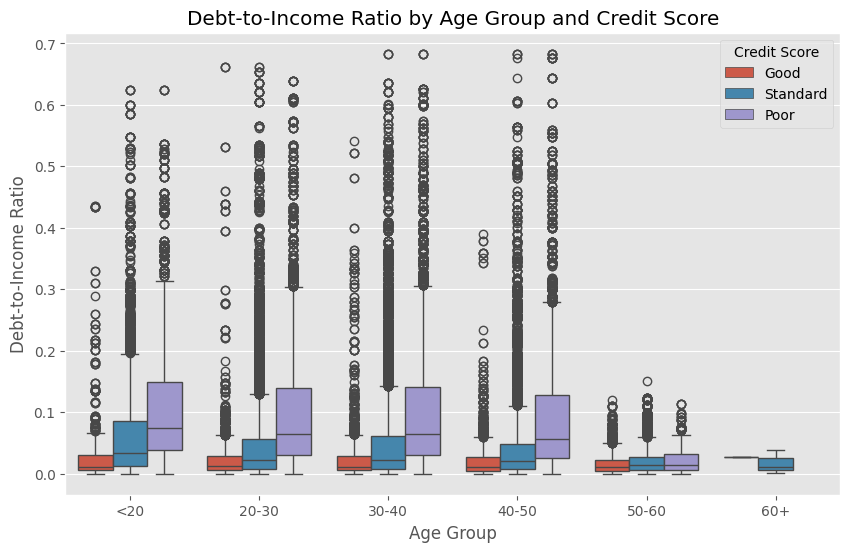

In [ ]:
# Step 3: Feature Relationships
# Boxplot of Age_Group vs Credit_Score
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_Group', y='Debt_to_Income_Ratio', hue='Credit_Score', data=credit_score_df)
plt.title('Debt-to-Income Ratio by Age Group and Credit Score')
plt.xlabel('Age Group')
plt.ylabel('Debt-to-Income Ratio')
plt.legend(title='Credit Score')
plt.show()

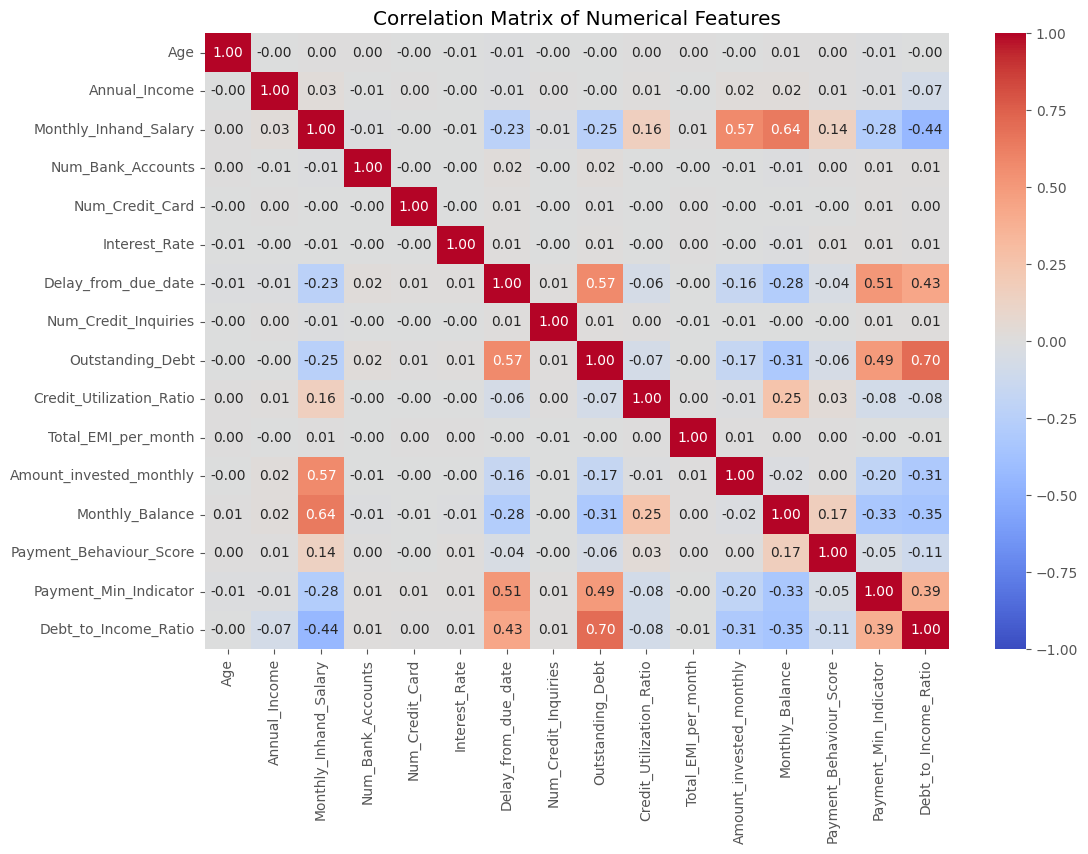

In [ ]:
# Correlation Heatmap for numerical features
numerical_features = credit_score_df.select_dtypes(include=['float64', 'int64']).drop(columns=['Credit_History_Months'])
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# **Step 5: Building Predictive Models**

With the insights in place, machine learning models were tasked with predicting credit scores.

1. Data Splitting:
   * 70% of the data was used for training, while 30% was reserved for testing.
2. Target Encoding:
   * The target variable **`Credit_Score`** was encoded into numeric values for compatibility.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode the target variable
label_encoder = LabelEncoder()
credit_score_df['Credit_Score_Normal'] = label_encoder.fit_transform(credit_score_df['Credit_Score'])

# Step 2: Select features and target variable
# Features: Select key numerical and encoded categorical features
features = [
    'Payment_Behaviour_Score', 'Payment_Min_Indicator', 'Debt_to_Income_Ratio',
    'Credit_Utilization_Ratio', 'Monthly_Balance', 'Total_EMI_per_month',
    'Occupation_Encoded', 'Credit_History_Months', 'Num_Credit_Card',
    'Num_Bank_Accounts', 'Age'
]
X = credit_score_df[features]
y = credit_score_df['Credit_Score_Normal']

# Handle missing values in features by filling with median
X = X.fillna(X.median())

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Confirm the dataset sizes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70000, 11), (30000, 11), (70000,), (30000,))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Step 1: Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
logistic_prob = logistic_model.predict_proba(X_test) # Get probabilities for all classes

# Step 2: Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)  # Get probabilities for all classes

# Step 3: Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)  # Get probabilities for all classes

# Step 4: Evaluate Models
def evaluate_model(y_test, predictions, probabilities, model_name):
    # Get unique classes from y_test
    unique_classes = np.unique(y_test)

    # Get target names for the unique classes
    target_names = label_encoder.classes_[unique_classes]

    report = classification_report(y_test, predictions, target_names=target_names, labels=unique_classes)

    # Ensure probabilities align with unique classes and sum to 1
    # Select columns corresponding to unique classes
    probabilities_filtered = probabilities[:, unique_classes]

    # Normalize probabilities to ensure they sum to 1 for each sample
    probabilities_normalized = probabilities_filtered / probabilities_filtered.sum(axis=1, keepdims=True)

    roc_auc = roc_auc_score(y_test, probabilities_normalized, multi_class='ovr', labels=unique_classes)
    print(f"Model: {model_name}")
    print(report)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("-" * 50)

# Evaluate Logistic Regression
evaluate_model(y_test, logistic_pred, logistic_prob, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(y_test, rf_pred, rf_prob, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, xgb_pred, xgb_prob, "XGBoost")

Model: Logistic Regression
              precision    recall  f1-score   support

        Good       0.38      0.02      0.05      5322
        Poor       0.42      0.15      0.22      8805
    Standard       0.53      0.89      0.67     15873

    accuracy                           0.52     30000
   macro avg       0.44      0.36      0.31     30000
weighted avg       0.47      0.52      0.43     30000

ROC-AUC Score: 0.6469
--------------------------------------------------
Model: Random Forest
              precision    recall  f1-score   support

        Good       0.72      0.60      0.66      5322
        Poor       0.75      0.73      0.74      8805
    Standard       0.75      0.80      0.77     15873

    accuracy                           0.74     30000
   macro avg       0.74      0.71      0.72     30000
weighted avg       0.74      0.74      0.74     30000

ROC-AUC Score: 0.8811
--------------------------------------------------
Model: XGBoost
              precision    re

# **Explanation of Oversampling**

**Oversampling** is a technique used to address class imbalance in classification problems, where one or more classes are underrepresented compared to others. This imbalance can lead to biased models that perform poorly on the minority class.


The provided code uses **SMOTE** (**Synthetic Minority Over-sampling Technique**) for oversampling.

Balanced Class Distribution:
Credit_Score_Encoded
0    33.333333
2    33.333333
1    33.333333
Name: proportion, dtype: float64


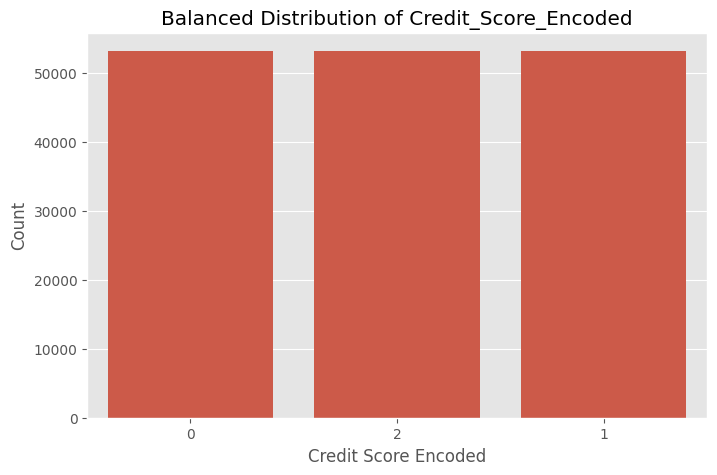

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode the target variable
label_encoder = LabelEncoder()
credit_score_df['Credit_Score_Encoded'] = label_encoder.fit_transform(credit_score_df['Credit_Score'])

# Step 2: Select features and target variable
# Features: Select key numerical and encoded categorical features
features = [
    'Payment_Behaviour_Score', 'Payment_Min_Indicator', 'Debt_to_Income_Ratio',
    'Credit_Utilization_Ratio', 'Monthly_Balance', 'Total_EMI_per_month',
    'Occupation_Encoded', 'Credit_History_Months', 'Num_Credit_Card',
    'Num_Bank_Accounts', 'Age'
]
X = credit_score_df[features]
y = credit_score_df['Credit_Score_Encoded']

# Handle missing values in features by filling with median
X = X.fillna(X.median())

# Step 3: Apply SMOTE for Balancing
# Define features (X) and target (y)
# Instead of dropping 'Credit_Score', use the original credit_score_df with all features
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert resampled data back to a DataFrame for analysis
balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
balanced_df['Credit_Score_Encoded'] = y_resampled

# Step 4: Verify New Class Distribution
print("Balanced Class Distribution:")
print(balanced_df['Credit_Score_Encoded'].value_counts(normalize=True) * 100)

# Step 5: Visualize Balanced Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='Credit_Score_Encoded', data=balanced_df, order=balanced_df['Credit_Score_Encoded'].value_counts().index)
plt.title('Balanced Distribution of Credit_Score_Encoded')
plt.xlabel('Credit Score Encoded')
plt.ylabel('Count')
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Step 6: Split Oversampled Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)

# Step 7: Train Logistic Regression
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
logistic_pred = logistic_model.predict(X_test)
logistic_prob = logistic_model.predict_proba(X_test)  # Get probabilities for all classes

# Step 8: Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_prob = rf_model.predict_proba(X_test)  # Get probabilities for all classes

# Step 9: Train XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_prob = xgb_model.predict_proba(X_test)  # Get probabilities for all classes

# Step 10: Evaluate Models
def evaluate_model(y_test, predictions, probabilities, model_name):
    # Ensure probabilities align with unique classes and sum to 1
    probabilities_normalized = probabilities / probabilities.sum(axis=1, keepdims=True)

    report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
    roc_auc = roc_auc_score(y_test, probabilities_normalized, multi_class='ovr')

    print(f"Model: {model_name}")
    print(report)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("-" * 50)

# Evaluate Logistic Regression
evaluate_model(y_test, logistic_pred, logistic_prob, "Logistic Regression")

# Evaluate Random Forest
evaluate_model(y_test, rf_pred, rf_prob, "Random Forest")

# Evaluate XGBoost
evaluate_model(y_test, xgb_pred, xgb_prob, "XGBoost")

Model: Logistic Regression
              precision    recall  f1-score   support

        Good       0.52      0.65      0.57     15952
        Poor       0.53      0.63      0.58     15952
    Standard       0.37      0.22      0.27     15953

    accuracy                           0.50     47857
   macro avg       0.48      0.50      0.48     47857
weighted avg       0.48      0.50      0.48     47857

ROC-AUC Score: 0.6537
--------------------------------------------------
Model: Random Forest
              precision    recall  f1-score   support

        Good       0.80      0.87      0.84     15952
        Poor       0.80      0.79      0.80     15952
    Standard       0.76      0.70      0.73     15953

    accuracy                           0.79     47857
   macro avg       0.79      0.79      0.79     47857
weighted avg       0.79      0.79      0.79     47857

ROC-AUC Score: 0.9251
--------------------------------------------------
Model: XGBoost
              precision    re

<Figure size 800x600 with 0 Axes>

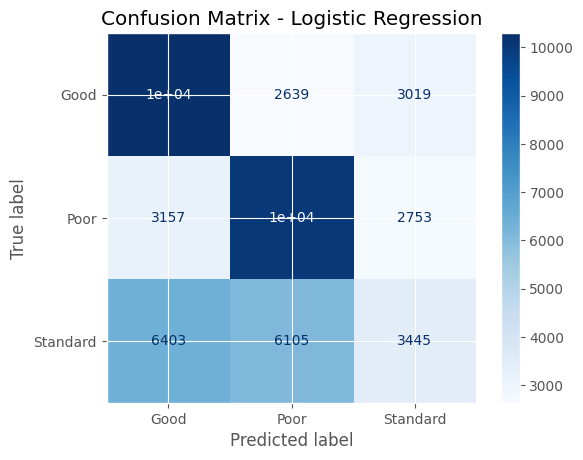

<Figure size 800x600 with 0 Axes>

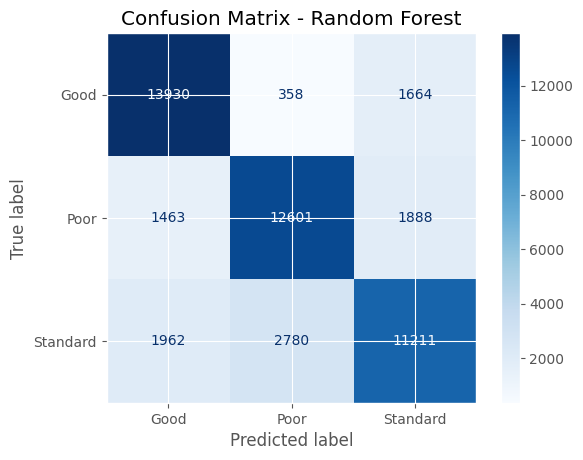

<Figure size 800x600 with 0 Axes>

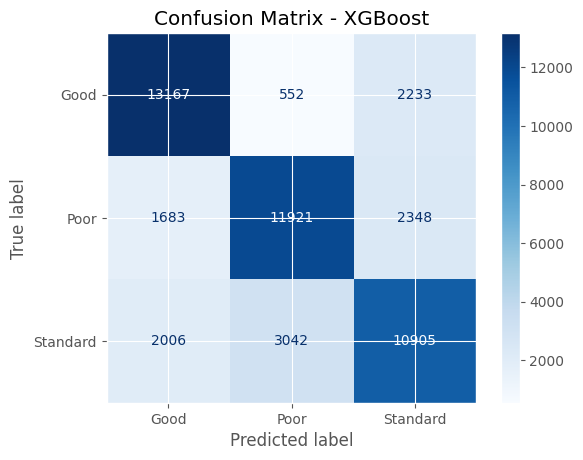

In [ ]:
# Step 5: Visualize confusion matrices for Logistic Regression and Random Forest
# Logistic Regression
plt.figure(figsize=(8, 6))
logistic_cm = confusion_matrix(y_test, logistic_pred)

# Get unique classes present in y_test
unique_classes = np.unique(y_test)

# Filter display labels to match unique classes
display_labels = label_encoder.classes_[unique_classes]

ConfusionMatrixDisplay(logistic_cm, display_labels=display_labels).plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Random Forest
plt.figure(figsize=(8, 6))
rf_cm = confusion_matrix(y_test, rf_pred)

# Use unique classes and display labels obtained from Logistic Regression section
ConfusionMatrixDisplay(rf_cm, display_labels=display_labels).plot(cmap="Blues") # Use display_labels here
plt.title("Confusion Matrix - Random Forest")
plt.show()

# XGBoost Forest
plt.figure(figsize=(8, 6))
xgb_cm = confusion_matrix(y_test, xgb_pred)  # Corrected: Use xgb_cm
ConfusionMatrixDisplay(xgb_cm, display_labels=display_labels).plot(cmap="Blues") # Use display_labels and xgb_cm
plt.title("Confusion Matrix - XGBoost")  # Corrected: Title reflects XGBoost
plt.show()

In [ ]:
# Re-import the necessary function for evaluation
from sklearn.metrics import classification_report

# Get the unique classes present in y_test
unique_classes = np.unique(y_test)

# Filter target names to match the unique classes in y_test
target_names = label_encoder.classes_[unique_classes]

# Generate the classification report for Random Forest
rf_report = classification_report(y_test, rf_pred, target_names=target_names, labels=unique_classes)
print("Random Forest Classification Report:\n", rf_report)


Random Forest Classification Report:
               precision    recall  f1-score   support

        Good       0.80      0.87      0.84     15952
        Poor       0.80      0.79      0.80     15952
    Standard       0.76      0.70      0.73     15953

    accuracy                           0.79     47857
   macro avg       0.79      0.79      0.79     47857
weighted avg       0.79      0.79      0.79     47857



# **Step 6: Refinement Through Hyperparameter Tuning**

Using **`GridSearchCV`**, the Random Forest model was optimized:

* Parameters Tested:
  * Number of trees (**`n_estimators`**): 50, 100, 200.
  * Maximum depth (**`max_depth`**): 10, 20, None.
  * Minimum samples split (**`min_samples_split`**): 2, 5, 10.

* Best Configuration:
  * **`n_estimators=200`**, **`max_depth=None`**, **`min_samples_split=2`**.

The optimized model delivered consistent accuracy and better generalization.



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest with GridSearchCV
rf_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit the model to training data
rf_grid_search.fit(X_train, y_train)

# Retrieve the best parameters and best estimator
best_rf_model = rf_grid_search.best_estimator_
best_params = rf_grid_search.best_params_

best_params

Fitting 3 folds for each of 81 candidates, totalling 243 fits


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

Model: Random Forest (Tuned)
              precision    recall  f1-score   support

           0       0.80      0.88      0.84     15952
           1       0.80      0.79      0.80     15952
           2       0.76      0.70      0.73     15953

    accuracy                           0.79     47857
   macro avg       0.79      0.79      0.79     47857
weighted avg       0.79      0.79      0.79     47857

ROC-AUC Score: 0.9266
--------------------------------------------------
Best Hyperparameters:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


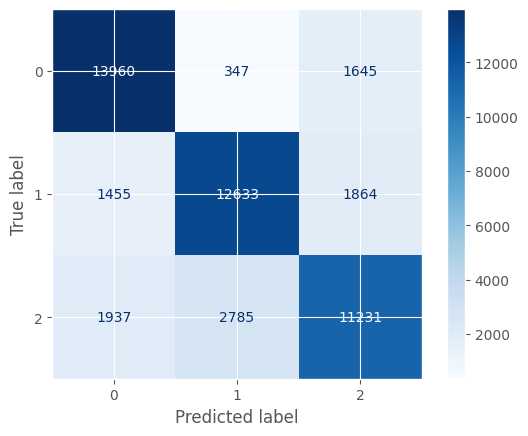

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Evaluate Model Performance After Hyperparameter Tuning
def evaluate_tuned_model(y_test, predictions, probabilities, model_name):
    unique_classes = np.unique(y_test)

    # Classification report
    report = classification_report(y_test, predictions)

    # Ensure probabilities align with unique classes
    probabilities_filtered = probabilities[:, unique_classes]
    probabilities_normalized = probabilities_filtered / probabilities_filtered.sum(axis=1, keepdims=True)

    # ROC-AUC score
    roc_auc = roc_auc_score(y_test, probabilities_normalized, multi_class='ovr')

    # Print metrics
    print(f"Model: {model_name} (Tuned)")
    print(report)
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print("-" * 50)

    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap='Blues')
    return roc_auc

# Predictions and probabilities for the best model
best_rf_pred = best_rf_model.predict(X_test)
best_rf_prob = best_rf_model.predict_proba(X_test)

# Evaluate the best model
best_rf_roc_auc = evaluate_tuned_model(y_test, best_rf_pred, best_rf_prob, "Random Forest")

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# **Step 7: Feature Importance**

To understand the model’s decisions, feature importance was extracted from the Random Forest model. The top predictors were:

1. **Debt-to-Income Ratio**: Financial stability indicator.
2. **Credit_History_Months**: Longer history correlated with better scores.
3. **Payment_Behaviour_Score**: Behavioral patterns influencing risk.
4. **Age**: Captured demographic trends in creditworthiness.

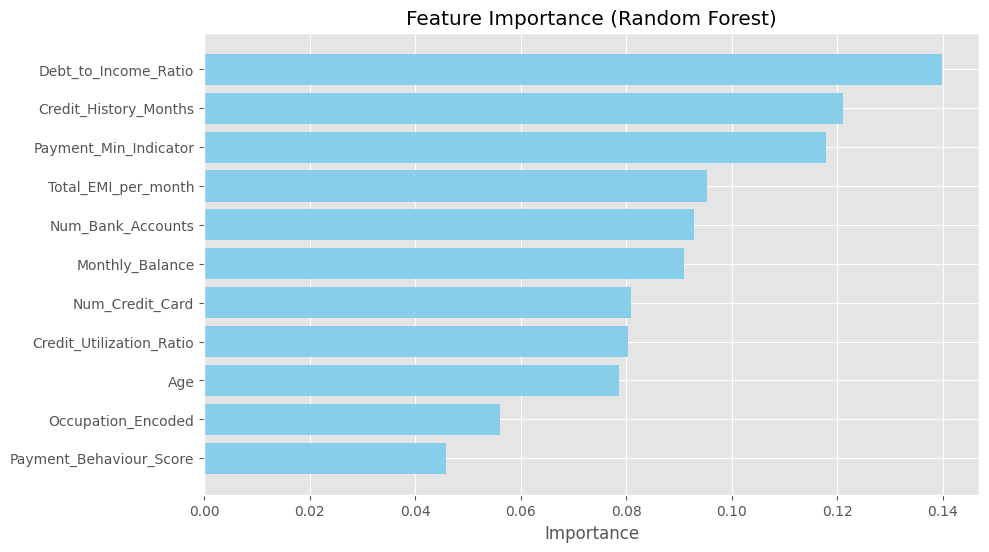

In [ ]:
# Step 1: Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 2: Extract feature importances
feature_importances = rf_model.feature_importances_
features = X_train.columns

# Step 3: Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Step 4: Plot the feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# **Final Results**

The Random Forest Classifier emerged as the best model:

* Accuracy: 79%
* ROC-AUC: 0.925
* Balanced performance across all categories.

# **Conclusion**

The **Credit Score Prediction Project** demonstrates the power of data-driven solutions in solving complex financial challenges, particularly in the domain of credit risk assessment. Through a systematic approach involving data cleaning, feature engineering, model development, and evaluation, the project has delivered actionable insights and a robust machine learning solution to predict customer credit scores.

**Key Achievements**

1. **Data Transformation and Preparation**:

  * The project began with raw data containing inconsistencies such as missing values, negative values, and mixed data formats. These issues were systematically addressed through imputation, correction, and standardization.

  * The transformation of **`Credit_History_Age`** into total months and the calculation of **`Debt-to-Income Ratio`** exemplified how raw data was converted into meaningful, predictive features.

2. **Feature Engineering**:

  * Critical behavioral, financial, and demographic features were extracted and engineered to enhance model performance. Features like **`Payment_Behaviour_Score`** and **`Age_Group`** provided valuable insights into customer creditworthiness.
  
  * These features not only improved the accuracy of predictions but also offered interpretability for stakeholders.

3. Model Development and Evaluation:

  * The use of multiple machine learning models (Logistic Regression, Random Forest, XGBoost) allowed for a comparative analysis of their performance.

  * The Random Forest Classifier emerged as the most effective model, achieving a **79% accuracy** and a **ROC-AUC score of 0.925**, highlighting its ability to handle complex relationships and imbalanced classes.

  * Comprehensive metrics such as **precision**, **recall**, and **F1-score** revealed the model's balanced performance across all credit score categories, ensuring fairness and reliability.

4. **Insights and Interpretability**:

  * Feature importance analysis identified key drivers of creditworthiness, such as:
     * Debt-to-Income Ratio: A clear indicator of financial stability.
     * Credit_History_Months: The significance of a customer’s credit history length.
     * Payment_Behaviour_Score: Behavioral tendencies impacting risk levels.
  * These insights provide financial institutions with actionable intelligence for making informed lending decisions.

5. **Model Optimization**:

  * Hyperparameter tuning using GridSearchCV further enhanced the performance of the Random Forest model, ensuring it generalizes well to unseen data.


# **Impact and Applications**

1. **Practical Applications**:

  * The model provides a scalable solution for financial institutions to assess credit risk, enabling more informed and accurate lending decisions.

  * It can serve as the backbone for automated credit scoring systems, reducing manual effort and enhancing consistency.

2. **Business Implications**:

  * By accurately categorizing customers into credit score tiers, institutions can:
     * Reduce default rates by identifying high-risk customers.
     * Tailor financial products to suit customer profiles.
     * Build trust with customers through fair and transparent credit decisions.

3. **Broader Use Cases**:

  * Beyond credit scoring, the methods and insights derived from this project can be applied to other domains, such as insurance risk assessment, customer segmentation, and fraud detection.


# **Future Enhancements**

While the project achieved significant milestones, there are opportunities for further improvement:

1. Feature Enrichment:
  * Incorporating additional data such as payment histories, utility bills, and alternative credit scores could enhance model accuracy.
2. Deep Learning Models:
  * Exploring neural networks for feature interactions and non-linear relationships could further boost performance.
3. Real-Time Scoring:
  * Deploying the model in production for real-time credit scoring would extend its practical utility.
4. Explainability:
  * Leveraging tools like SHAP or LIME for model interpretability could improve stakeholder confidence and understanding.


# **Final Thoughts**
This project is a testament to the transformative power of machine learning in financial services. By combining thoughtful data preparation, advanced modeling techniques, and actionable insights, the Credit Score Prediction Model stands as a robust solution for addressing credit risk challenges. It not only empowers financial institutions with accurate tools for decision-making but also fosters inclusivity by enabling fairer access to financial resources. With continual improvements and adaptations, this project lays the groundwork for revolutionizing credit scoring systems in the future.

In [ ]:
# Deployment Strategy via API

# 1. Serialize the model for deployment.
# 2. Use Flask or FastAPI to serve the model as an API.
# 3. Define endpoints for prediction requests.
# 4. Deploy using a cloud service (e.g., AWS, Google Cloud, Azure) or containerization (e.g., Docker).

from flask import Flask, request, jsonify
import joblib
import pandas as pd

# Load the pre-trained model
model = joblib.load('random_forest_model.pkl')

# Initialize Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Parse input JSON data
        input_data = request.get_json()

        # Convert to DataFrame (assuming JSON structure is compatible)
        input_df = pd.DataFrame([input_data])

        # Make prediction
        prediction = model.predict(input_df)
        probability = model.predict_proba(input_df).max(axis=1)

        # Return prediction and probability
        return jsonify({
            'prediction': int(prediction[0]),
            'probability': float(probability[0])
        })
    except Exception as e:
        return jsonify({'error': str(e)})

if __name__ == '__main__':
    app.run(debug=True, host='0.0.0.0', port=5000)

# Monitoring Strategy

# 1. Accuracy Monitoring:
#    - Continuously evaluate predictions against actual outcomes.
#    - Use a scheduled batch process to compute accuracy metrics.

# 2. Drift Detection:
#    - Track distribution of input features and predictions over time.
#    - Use statistical tests (e.g., KS test) to identify significant deviations.

# 3. Performance Metrics:
#    - Log response times and error rates.
#    - Implement application monitoring tools like Prometheus/Grafana.

# 4. Feedback Loop:
#    - Incorporate new labeled data periodically.
#    - Retrain the model to address changes in data distribution or behavior.

# 5. Alerting:
#    - Set thresholds for accuracy or drift metrics.
#    - Trigger alerts when thresholds are breached.

# To extend monitoring, integrate with a logging service (e.g., ELK stack, Datadog) and define alerts for anomalies.


# **1. Scalable Data Pipeline**

A robust, distributed, and fault-tolerant pipeline ensures that data processing can keep up with increasing volumes.

**a. Ingestion**:
* Use scalable ingestion frameworks like Apache Kafka, Amazon Kinesis, or Google Pub/Sub for real-time streaming data.
* For batch data, rely on cloud-based storage like AWS S3, Google Cloud Storage, or Azure Blob Storage with tools like Apache Airflow or Luigi for orchestration.

**b. Processing**:
* Adopt distributed frameworks like Apache Spark, Databricks, or Google Dataflow for large-scale data transformations.
* Partition the data by time (e.g., hourly or daily) or other logical keys (e.g., customer ID, region) to process data in parallel.

**c. Storage**:
* Use scalable, cloud-based data warehouses such as:
  * Google BigQuery (columnar storage optimized for analytics).
  * Snowflake or Amazon Redshift for structured data.

* For NoSQL storage, consider Cassandra or MongoDB to handle semi-structured data.

**d. Data Quality and Validation**:
* Automate quality checks with tools like Great Expectations or custom validation scripts.
* Maintain metadata and lineage using Apache Atlas or DataHub.


# **2. Scalable Model Design**

To handle increasing data and prediction demands, focus on distributed computing, modularity, and efficient retraining.

**a. Model Training:**

* Use distributed machine learning frameworks like:
  * TensorFlow Extended (TFX) or PyTorch Lightning.
  * Dask-ML for distributed dataframes and ML pipelines.
  * H2O.ai for scalable auto-ML.

* Train models on GPU-enabled infrastructure or distributed computing platforms like Google AI Platform, Databricks, or AWS SageMaker.

* Implement incremental learning or online learning for models to adapt to new data without retraining from scratch.

**b. Model Serving:**
* Use scalable serving solutions:
  * TensorFlow Serving or TorchServe for ML frameworks.
  * Kubernetes to deploy containerized APIs (e.g., Flask or FastAPI apps).
  * AWS Lambda or Google Cloud Functions for serverless deployments.

* Implement load balancing with tools like NGINX or cloud-native solutions (e.g., AWS ALB).

**c. Retraining Strategy:**
* Automate retraining pipelines using orchestration tools like Kubeflow Pipelines or MLflow.
* Use event-driven retraining (e.g., new data triggers retraining jobs) or schedule retraining (e.g., weekly/monthly).

# **3. Scalable Monitoring and Logging**

Monitor and log both data pipeline and model performance to identify bottlenecks and anomalies.

**a. Data Pipeline Monitoring:**

Monitor data freshness, latency, and completeness using Prometheus/Grafana or cloud-native monitoring tools (e.g., AWS CloudWatch).

**b. Model Monitoring:**
* Track metrics such as accuracy, precision, recall, and drift.
* Implement real-time monitoring tools like Evidently AI or custom dashboards.

**c. Logging and Alerts:**
* Use centralized logging systems like ELK Stack (Elasticsearch, Logstash, Kibana) or Datadog.
* Set alerts for pipeline failures, slow processing times, or model performance degradation.

# **4. Scalability Best Practices**
* **Microservices Architecture**: Break the pipeline and model serving into independent services for modular scaling.
* **Containerization**: Use Docker and Kubernetes to manage workloads dynamically.
* **Cloud-Native Solutions**: Rely on managed services to reduce operational overhead.
* **Horizontal Scaling**: Add more nodes to handle increased data and compute load.
* **Data Partitioning**: Use sharding and partitioning strategies to divide workloads logically.

# **5. Real-Life Example Workflow**
* **Ingestion**: Kafka streams user interaction data into AWS S3 in near real-time.
* **Processing**: Spark on AWS EMR transforms the data and stores it in Snowflake.
* **Model Training**: Distributed training on SageMaker using AutoML or custom frameworks.
* **Deployment**: Serve the model as an API on Kubernetes with auto-scaling.
* **Monitoring**: Use Prometheus for pipeline metrics and Evidently AI for model drift detection.
